In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotx
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import display, HTML

In [2]:
data = pd.read_csv('sales_data.csv')
display(data.head(6))

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5%,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Los Angeles,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/19,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Atlanta,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/19,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Los Angeles,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/19,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Los Angeles,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/19,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Los Angeles,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/19,10:37,Ewallet,604.17,4.761905,30.2085,5.3
5,699-14-3026,C,Atlanta,Normal,Male,Electronic accessories,85.39,7,29.8865,627.6165,3/25/19,18:30,Ewallet,597.73,4.761905,29.8865,4.1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   invoice_id               1000 non-null   object 
 1   branch                   1000 non-null   object 
 2   city                     1000 non-null   object 
 3   customer_type            1000 non-null   object 
 4   gender                   1000 non-null   object 
 5   product_line             1000 non-null   object 
 6   unit_price               1000 non-null   float64
 7   quantity                 1000 non-null   int64  
 8   tax_5%                   1000 non-null   float64
 9   total                    1000 non-null   float64
 10  date                     1000 non-null   object 
 11  time                     1000 non-null   object 
 12  payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross_margin_percentage  

In [4]:
sales_data = pd.DataFrame(data[['date', 'total']])

sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data['date'] = sales_data['date'].dt.to_period("D")

daily_sales = sales_data.groupby('date').sum().reset_index()

daily_sales['date'] = daily_sales['date'].dt.to_timestamp()

In [5]:
display(daily_sales.head(6))

,date,total
0,2019-01-01,4745.1810
1,2019-01-02,1945.5030
2,2019-01-03,2078.1285
3,2019-01-04,1623.6885
4,2019-01-05,3536.6835
5,2019-01-06,3614.2050


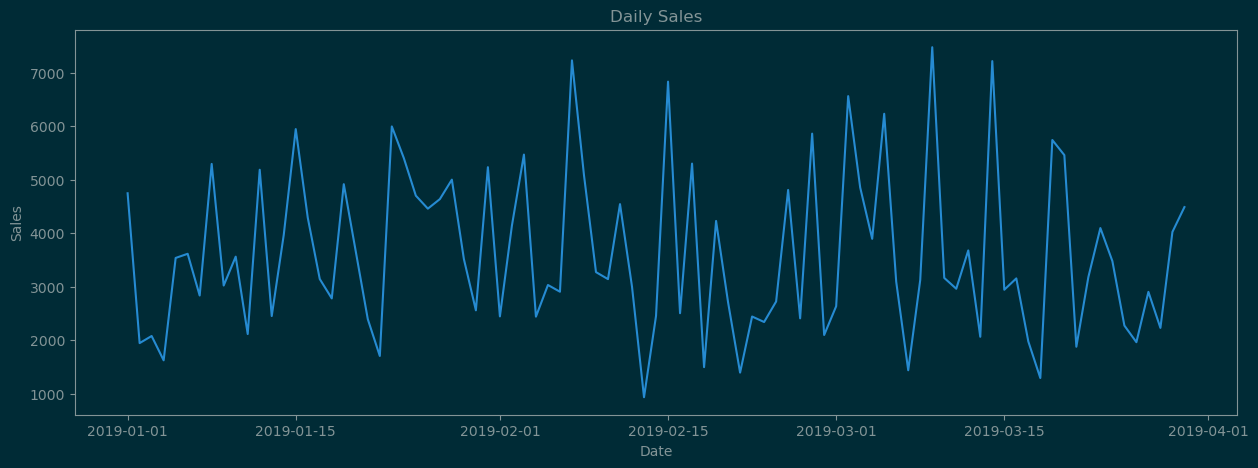

In [6]:
with plt.style.context(matplotx.styles.solarized):
    plt.figure(figsize=(15, 5))
    plt.plot(daily_sales['date'], daily_sales['total'])
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title("Daily Sales")
    plt.show()

In [7]:
daily_sales['sales_diff'] = daily_sales['total'].diff()
daily_sales = daily_sales.dropna()
display(daily_sales.head(10))

,date,total,sales_diff
1,2019-01-02,1945.5030,-2799.6780
2,2019-01-03,2078.1285,132.6255
3,2019-01-04,1623.6885,-454.4400
4,2019-01-05,3536.6835,1912.9950
5,2019-01-06,3614.2050,77.5215
6,2019-01-07,2834.2440,-779.9610
7,2019-01-08,5293.7325,2459.4885
8,2019-01-09,3021.3435,-2272.3890
9,2019-01-10,3560.9490,539.6055
10,2019-01-11,2114.9625,-1445.9865


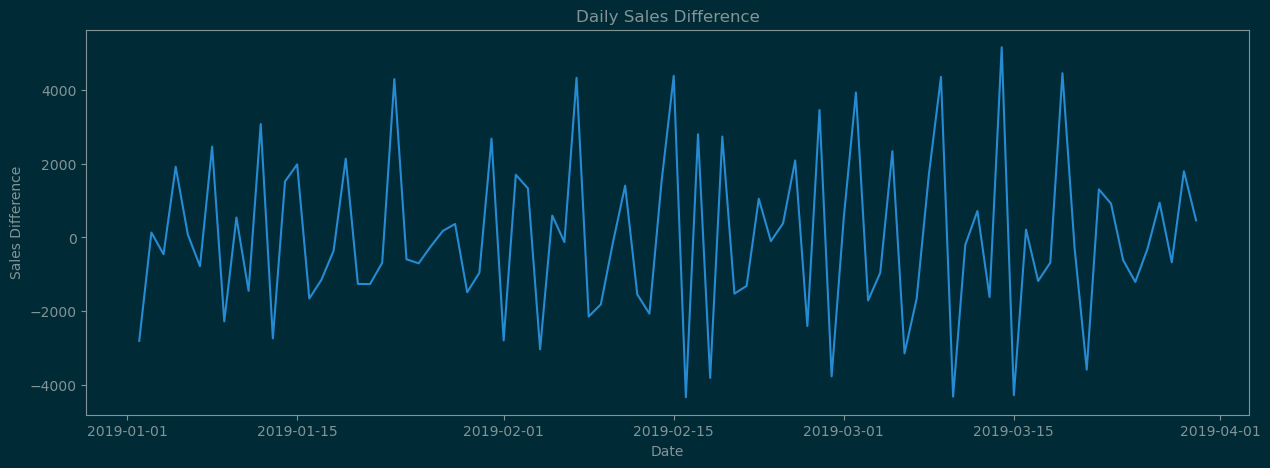

In [8]:
with plt.style.context(matplotx.styles.solarized):
    plt.figure(figsize=(15, 5))
    plt.plot(daily_sales['date'], daily_sales['sales_diff'])
    plt.xlabel('Date')
    plt.ylabel('Sales Difference')
    plt.title("Daily Sales Difference")
    plt.show()

In [9]:
supervised_data = daily_sales.drop(['date', 'total'], axis=1)

In [10]:
for i in range(1, 8):
    col_name = 'day_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)

In [11]:
supervised_data.head(10)

,sales_diff,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,-2272.3890,2459.4885,-779.9610,77.5215,1912.9950,-454.4400,132.6255,-2799.6780
1,539.6055,-2272.3890,2459.4885,-779.9610,77.5215,1912.9950,-454.4400,132.6255
2,-1445.9865,539.6055,-2272.3890,2459.4885,-779.9610,77.5215,1912.9950,-454.4400
3,3069.8010,-1445.9865,539.6055,-2272.3890,2459.4885,-779.9610,77.5215,1912.9950
4,-2733.5595,3069.8010,-1445.9865,539.6055,-2272.3890,2459.4885,-779.9610,77.5215
5,1515.4125,-2733.5595,3069.8010,-1445.9865,539.6055,-2272.3890,2459.4885,-779.9610
6,1977.6435,1515.4125,-2733.5595,3069.8010,-1445.9865,539.6055,-2272.3890,2459.4885
7,-1655.1780,1977.6435,1515.4125,-2733.5595,3069.8010,-1445.9865,539.6055,-2272.3890
8,-1146.3270,-1655.1780,1977.6435,1515.4125,-2733.5595,3069.8010,-1445.9865,539.6055
9,-362.2815,-1146.3270,-1655.1780,1977.6435,1515.4125,-2733.5595,3069.8010,-1445.9865


In [12]:
z = 21
train_data = supervised_data[:-z]
test_data = supervised_data[-z:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (60, 8)
Test Data Shape:  (21, 8)


In [13]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [14]:
x_train, y_train = train_data[:, 1:], train_data[:, 0:1]
x_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", x_train.shape)
print("Y_train Shape: ", y_train.shape)
print("X_test Shape: ", x_test.shape)
print("Y_test Shape: ", y_test.shape)

X_train Shape:  (60, 7)
Y_train Shape:  (60,)
X_test Shape:  (21, 7)
Y_test Shape:  (21,)


In [15]:
sales_dates = daily_sales['date'][-z:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [16]:
act_sales = daily_sales['total'][-z:].to_list()
print(act_sales)

[3163.23, 2961.252, 3677.5515, 2063.607, 7214.634, 2942.415, 3154.473, 1976.289, 1292.8335, 5740.392, 5458.2045, 1877.5155, 3179.148, 4095.042, 3477.4635, 2272.9665, 1962.5130000000001, 2902.8195, 2229.402, 4023.243, 4487.0595]


In [17]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [18]:
lr_pre = lr_pre.reshape(-1, 1)
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [19]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)
print(predict_df)

         date  Linear Prediction
0  2019-03-10         736.102161
1  2019-03-11        3546.596303
2  2019-03-12        5125.079523
3  2019-03-13        3564.761344
4  2019-03-14        8281.719524
5  2019-03-15       -1449.138552
6  2019-03-16        4572.839183
7  2019-03-17        3643.986690
8  2019-03-18        3206.932147
9  2019-03-19        7896.585499
10 2019-03-20        2811.522438
11 2019-03-21          49.000912
12 2019-03-22        5600.331288
13 2019-03-23        4655.623565
14 2019-03-24        3009.136361
15 2019-03-25        1189.979729
16 2019-03-26        2850.972106
17 2019-03-27        5702.914238
18 2019-03-28        3056.840971
19 2019-03-29        4314.266864
20 2019-03-30        3612.098198


In [20]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], daily_sales['total'][-z:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], daily_sales['total'][-z:])
lr_r2 = r2_score(predict_df['Linear Prediction'], daily_sales['total'][-z:])


print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  1854.1391990011548
Linear Regression MAE:  1584.1144285444295
Linear Regression R2:  0.33025374296692567


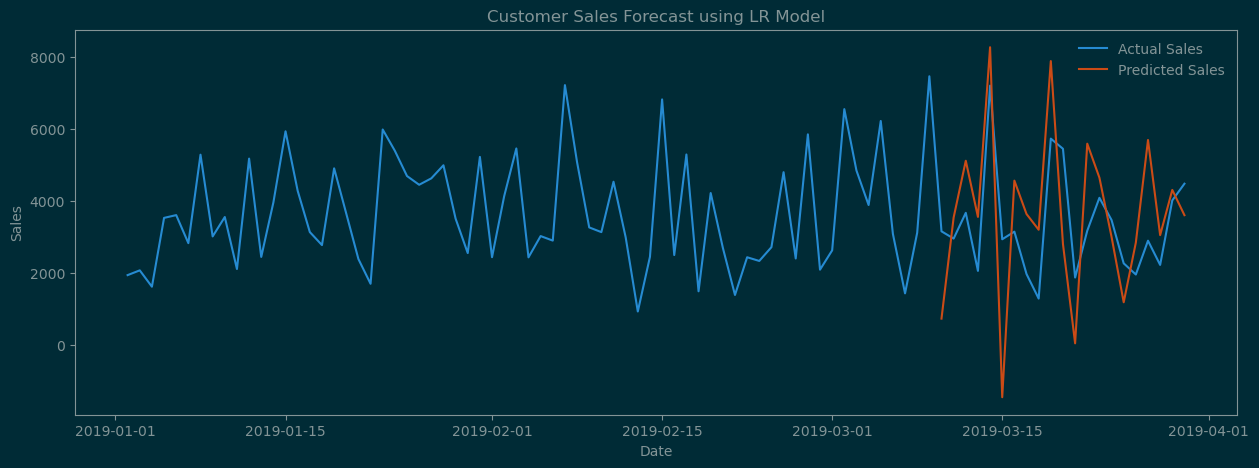

In [21]:
with plt.style.context(matplotx.styles.solarized):
    plt.figure(figsize=(15, 5))
    plt.plot(daily_sales['date'], daily_sales['total'])
    plt.plot(predict_df['date'], predict_df['Linear Prediction'])
    plt.title("Customer Sales Forecast using LR Model")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend(['Actual Sales', 'Predicted Sales'])
    plt.show()